<font size=8> F-I curve test

In [1]:
from adaptation import  ff_network, pc_pv_sst, pc_pv,pc_single,pv_single,ff_pc_pv,ff,sst_single,pc_pv_de
from adaptation_lib import dynapse_setup,graphing,tc_extraction
from measure import meas_syn_tau
import numpy as np
import matplotlib.pyplot as plt
from configs.neuron_configs import neuron_configs
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt



In [2]:
[board,profile_path,number_of_chips]=dynapse_setup.obtain_board()

In [3]:
print(np.linspace(0,250,5,dtype=int))

[  0  62 125 187 250]


In [4]:
neuron_config=neuron_configs()
neuron_config['input']='DC'
neuron_config['DC_Latches']=True
neuron_config['PC_GAIN']=[0,10]
neuron_config['PC_LEAK']=[1,46]
#the lower the refreactor paramater the more slanted and curving  the fi curve is
neuron_config['PC_REF']=[1,80]
neuron_config['PC_SPK_THR']=[2,30]
neuron_config['PC_DC']=[0,0]
neuron_config['PV_GAIN']=[2,20]
neuron_config['PV_LEAK']=[1,88]
neuron_config['PV_REF']=[2,140]
neuron_config['PV_SPK_THR']=[4,80]
neuron_config['PV_DC']=[0,0]
neuron_config['SST_GAIN']=[1,40]
neuron_config['SST_LEAK']=[1,44]
neuron_config['SST_REF']=[1,140]
neuron_config['SST_SPK_THR']=[3,160]
neuron_config['SST_DC']=[0,0]
#set DC range values for F-I curve
neuron_config['DC_FI_Range']=np.linspace(0,250,10,dtype=int)
neuron_config['DC_Coarse']=4
FF_output=ff.ff_single_neurons(board=board, profile_path=profile_path, number_of_chips=number_of_chips,neuron_config=neuron_config)
data_path='/home/hector/Documents/dynapse-se2-data/time_constant_tests/'
np.save(data_path+'FF_output.npy',FF_output)

Setting Latches
Setting monitors
250 250 250


PC Neurons

[221, 235, 239, 255, 201, 211, 223, 230, 252, 253, 237, 234, 236, 250, 169, 180, 183, 189, 204, 227, 242, 188, 194, 207, 248, 251, 203, 215, 219, 228, 196, 165, 171, 181, 195, 220, 222, 244, 149, 156, 164, 179, 205, 206, 217, 226, 238, 254, 148, 157, 158, 210, 214, 232, 245, 246, 131, 152, 161, 163, 167, 173, 176, 198, 200, 209, 231, 233, 113, 146, 170, 190, 192, 197, 229, 247, 249, 115, 118, 139, 141, 143, 159, 160, 166, 186, 202, 213, 218, 107, 134, 151, 155, 162, 177, 191, 216, 225, 243, 116, 126, 130, 140, 145, 168, 175, 182, 185, 187, 224, 129, 147, 150, 172, 241, 70, 114, 121, 132, 178, 212, 100, 119, 124, 133, 174, 199, 84, 108, 120, 125, 137, 154, 240, 98, 101, 135, 142, 184, 193, 68, 85, 112, 138, 67, 128, 99, 106, 109, 117, 122, 123, 136, 153, 66, 69, 71, 86, 88, 97, 102, 144, 208, 56, 77, 93, 111, 38, 50, 74, 81, 83, 51, 53, 65, 73, 79, 87, 91, 127, 27, 54, 72, 90, 94, 103, 104, 105, 20, 37, 39, 59, 64, 75, 96, 19, 2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


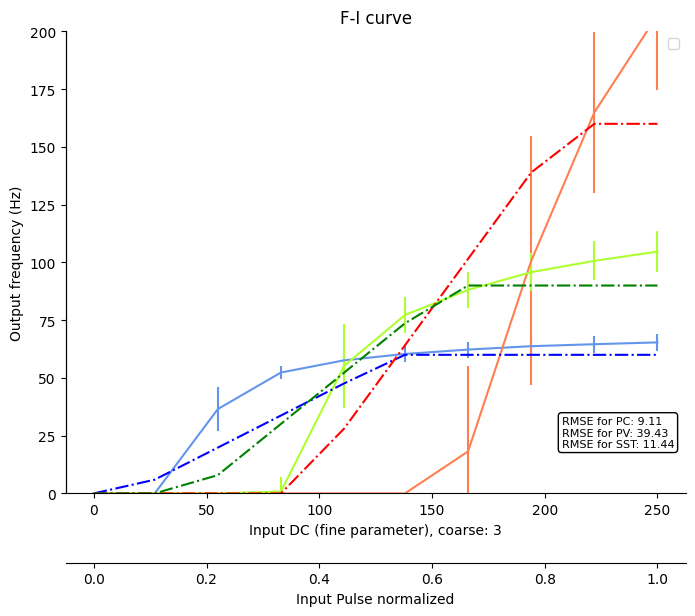

In [13]:
neuron_config=neuron_configs()

# Load your data
data_path='/home/hector/Documents/dynapse-se2-data/time_constant_tests/'

FF_output = np.load(data_path+'FF_output.npy', allow_pickle=True)
[FF_in, FF_out_PC, FF_out_PV, FF_out_SST, FF_cv] = FF_output

window=len(FF_in)
means_PC = np.mean(FF_out_PC, axis=0)[:window]
stds_PC = np.std(FF_out_PC, axis=0)[:window]
means_PV = np.mean(FF_out_PV, axis=0)[:window]
stds_PV = np.std(FF_out_PV, axis=0)[:window]
means_SST = np.mean(FF_out_SST, axis=0)[:window]
stds_SST = np.std(FF_out_SST, axis=0)[:window]
FF_in = FF_in[:window]

# Normalize FF_in with your desired max_value (e.g., 200/250)
normalized_FF_in = tc_extraction.normalize_input(FF_in, max_value=250/250)

# Calculate the fitted values
fit_PC = tc_extraction.custom_relu((normalized_FF_in),.06,124,60) #threshold, gain, maximum firing rate
fit_PV = tc_extraction.custom_relu((normalized_FF_in),.36,334,160)
fit_SST = tc_extraction.custom_relu((normalized_FF_in),.18,198,90)

# Compute residuals
residuals_PC = means_PC - fit_PC
residuals_PV = means_PV - fit_PV
residuals_SST = means_SST - fit_SST

# Calculate root-mean-square error rounded to 2 decimal places

rmse_PC = np.sqrt(np.mean(residuals_PC**2))
rmse_PV = np.sqrt(np.mean(residuals_PV**2))
rmse_SST = np.sqrt(np.mean(residuals_SST**2))


#Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot with error bars vs input DC parameter
ax1.errorbar(FF_in, means_PC, yerr=stds_PC, c='cornflowerblue')
ax1.errorbar(FF_in, means_PV, yerr=stds_PV, c='coral')
ax1.errorbar(FF_in, means_SST, yerr=stds_SST, c='greenyellow')

ax1.legend()
ax1.set_title('F-I curve')
ax1.set_ylabel('Output frequency (Hz)')
ax1.set_xlabel(f'Input DC (fine parameter), coarse: {neuron_config["DC_Coarse"]}')

# Plot the fitted curves
ax2 = ax1.twiny()
ax2.plot(normalized_FF_in, fit_PC, 'b-.', label='PC fit')
ax2.plot(normalized_FF_in, fit_PV, 'r-.', label='PV fit')
ax2.plot(normalized_FF_in, fit_SST, 'g-.', label='SST fit')
ax2.set_ylim(0, 200)

# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.15))

# Remove right and top borders
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel('Input Pulse normalized')

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")


#create input annotation with rmse errors rounded to two decimal places

input_annotation = f'RMSE for PC: {np.round(rmse_PC,2)}\nRMSE for PV: {np.round(rmse_PV,2)}\nRMSE for SST: {np.round(rmse_SST,2)}'
ax1.annotate(input_annotation, xy=(.8, 0.1), xycoords='axes fraction', size=8, bbox=dict(boxstyle="round", fc="w"))


plt.show()

In [70]:
print(means_PC)
print(len(means_PC))
print(means_PC[0:len(means_PC)])


[ 0.     0.056 12.152 14.16  14.676 14.852 15.088 15.144 15.24  15.252
 15.344 15.332 15.416 15.408 15.364 15.468 15.464 15.408 15.468 15.472
 15.52  15.488 15.5   15.568 15.548]
25
[ 0.     0.056 12.152 14.16  14.676 14.852 15.088 15.144 15.24  15.252
 15.344 15.332 15.416 15.408 15.364 15.468 15.464 15.408 15.468 15.472
 15.52  15.488 15.5   15.568 15.548]


Optimized parameters: [1. 0.]


/home/hector/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


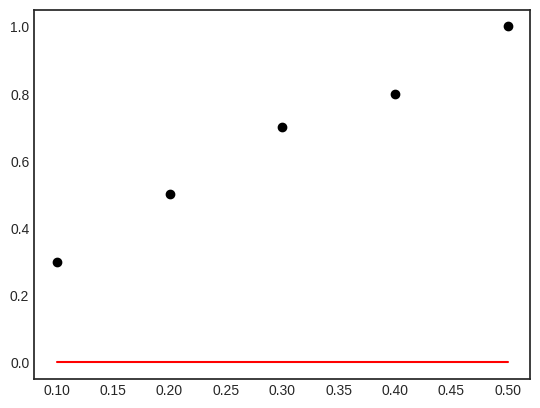

In [22]:
# Define the ReLU (Rectified Linear Unit) function
def relu(x, a,b):
    return np.maximum(0, x*b - a)

# Sample input data
FF_in_norm = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
FF_out_SST = np.array([0.3, 0.5, 0.7, 0.8, 1.0])

# Perform the curve fitting
popt, pcov = curve_fit(relu, FF_in_norm, FF_out_SST, p0=(1.0, 0.0))

print("Optimized parameters:", popt)
plt.plot(FF_in_norm, FF_out_SST, 'ko', label="Original Noised Data")
plt.plot(FF_in_norm, relu(FF_in_norm, *popt), 'r-', label="Fitted Curve")

In [6]:
[FF_in,FF_out_PC,FF_out_PV,FF_out_SST,FF_cv]=FF_output

#fit a linear relu function to the data
def relu(x,a,b):
    return np.maximum(a*x+b,0)

popt,pcov=curve_fit(relu,FF_in,FF_out_PC)
print(popt)
plt.plot(FF_in,FF_out_PC,'.')
plt.plot(FF_in,relu(FF_in,*popt))
plt.show()
#fit a linear relu function to the data
def relu(x,a,b):
    return np.maximum(a*x+b,0)
popt,pcov=curve_fit(relu,FF_in,FF_out_PV)
print(popt)
plt.plot(FF_in,FF_out_PV,'.')
plt.plot(FF_in,relu(FF_in,*popt))
plt.show()
#fit a linear relu function to the data
def relu(x,a,b):
    return np.maximum(a*x+b,0)
popt,pcov=curve_fit(relu,FF_in,FF_out_SST)
print(popt)
plt.plot(FF_in,FF_out_SST,'.')
plt.plot(FF_in,relu(FF_in,*popt))
plt.show()
#fit a linear relu function to the data
def relu(x,a,b):
    return np.maximum(a*x+b,0)

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

In [ ]:
neuron_config=neuron_configs.neuron_configs['duration']=0.5
frequency_vs_input_plot(FF_output, test_config,neuron_config, annotate=False)

In [11]:
type(FF_output)

NoneType